In [1]:
import pandas as pd
import geopandas as gpd
import rasterio
import requests
import zipfile
import io
import os
import numpy as np
import shutil
from shapely.geometry import Point

In [2]:

def load_data_from_url(url, zipped=False, filepath=None, **kwargs):
    """
    Extracts and returns raw data from a URL.

    Parameters:
    url : str
        The URL of the file to be extracted.
    zipped : bool, optional
        If True, the file is expected to be inside a zip file. Default is False.
    filepath : str, optional
        If zipped is True, this is the path to the file inside the archive.
    **kwargs :
        Additional arguments passed to the appropriate reader function 
        (e.g., pd.read_csv, pd.read_excel, gpd.read_file, rasterio.open)

    Returns:
    data : DataFrame, GeoDataFrame, or rasterio.DatasetReader
    """
    def detect_file_type(path):
        ext = os.path.splitext(path.lower())[1]
        if ext in ['.csv']: return 'csv'
        if ext in ['.txt']: return 'txt'
        elif ext in ['.xls']: return 'xls'
        elif ext in ['.xlsx']: return 'xlsx'
        elif ext in ['.shp', '.geojson', '.gpkg', '.json', '.kml']: return 'vector'
        elif ext in ['.tif', '.tiff']: return 'raster'
        else: return 'unknown'

    response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    if response.status_code != 200:
        response.raise_for_status()

    if not zipped:
        file_type = detect_file_type(url)
        buffer = io.BytesIO(response.content)

        if file_type == 'csv' or file_type == 'txt':
            data = pd.read_csv(buffer, low_memory=False, **kwargs)
        elif file_type == 'xls':
            data = pd.read_excel(buffer, engine='xlrd', **kwargs)
        elif file_type == 'xlsx':
            data = pd.read_excel(buffer, engine='openpyxl', **kwargs)
        elif file_type == 'vector':
            data = gpd.read_file(buffer, **kwargs).to_crs(saws_crs)
        elif file_type == 'raster':
            data = rasterio.open(buffer, **kwargs)
        else: # fallback on csv
            try:
                data = pd.read_csv(buffer, low_memory=False, **kwargs) 
            except:
                raise ValueError(f"Could not download data from this URL. Please check URL and try again.")

    else:
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
            if filepath is None:
                raise ValueError("Must specify 'filepath' within ZIP archive.")
            file_type = detect_file_type(filepath)

            try:
                with zip_file.open(filepath) as file:
                    if file_type == 'csv':
                        data = pd.read_csv(file, low_memory=False, **kwargs)
                    elif file_type == 'xls':
                        data = pd.read_excel(file, engine='xlrd', **kwargs)
                    elif file_type == 'xlsx':
                        data = pd.read_excel(file, engine='openpyxl', **kwargs)
                    elif file_type in ['vector', 'raster']:
                        raise NotImplementedError("Shapefiles and rasters require extraction.")
            except:
                zip_file.extractall('extracted_data')
                full_path = os.path.abspath(os.path.join('extracted_data', filepath))
                if file_type == 'csv':
                    data = pd.read_csv(full_path, low_memory=False, **kwargs)
                elif file_type == 'xls':
                    data = pd.read_excel(full_path, engine='xlrd', **kwargs)
                elif file_type == 'xlsx':
                    data = pd.read_excel(full_path, engine='openpyxl', **kwargs)
                elif file_type == 'vector':
                    data = gpd.read_file(full_path, **kwargs).to_crs(saws_crs)
                elif file_type == 'raster':
                    data = rasterio.open(full_path, **kwargs)
                shutil.rmtree('extracted_data')

    return data


def lat_long_to_point(df, lat_col, long_col):
    
    """
    This function takes a DataFrame with lat/long columns stored as floats
    and converts it into a GeoDataFrame with a point geometry.

    Arguments:
    df : DataFrame
        The DataFrame to be converted.
    lat_col : str
        The name of the column containing latitude values.
    long_col : str
        The name of the column containing longitude values.

    Returns:
    df : GeoDataFrame
        The modified DataFrame as a GeoDataFrame with point geometry.
    """

    df_geo = [Point(lon, lat) for lon, lat in zip(df[long_col], df[lat_col])]
    df = gpd.GeoDataFrame(df, geometry=df_geo, crs = 'EPSG:4326')
    df = df.to_crs(saws_crs)
    
    return df


In [3]:
data_url = 'https://www.sciencebase.gov/catalog/file/get/58937228e4b0fa1e59b73361?f=__disk__5a%2Fae%2F1a%2F5aae1aa25f84b94737628e43ef82e34f6897a63b'

data=load_data_from_url(data_url, zipped=True, filepath='Major_Ions.csv')
print(data.head())


  sourceID  unique_site_ID samp_id  proprietary_data state_alpha fips_cd  \
0    AZDEQ  AZDEQ-az000779     NaN                 0          AZ   04021   
1    AZDEQ  AZDEQ-az001146     NaN                 0          AZ   04013   
2    AZDEQ  AZDEQ-az002056     NaN                 0          AZ   04021   
3    AZDEQ  AZDEQ-az002153     NaN                 0          AZ   04021   
4    AZDEQ  AZDEQ-az006219     NaN                 0          AZ   04013   

  county_nm  dec_lat_va  dec_long_va location_flag  ...  \
0     Pinal   32.938241  -111.936083           2.0  ...   
1  Maricopa   33.005930  -112.676581           2.0  ...   
2     Pinal   32.676461  -111.516639           2.0  ...   
3     Pinal   33.065584  -111.975132           2.0  ...   
4  Maricopa   33.518722  -113.069351           2.0  ...   

   model_pp_Anhydrite_closed_16x  model_pp_Barite_closed_16x  \
0                            0.0                         0.0   
1                            0.0                         0.0

In [4]:
# Only include samples where TDS_mgL is greater than or equal to 1000
filtered_data = data[data['TDS_mgL'] >= 1000]

num_rows_total = len(data)  # total rows before filtering
num_rows_filtered = len(filtered_data)  # rows after filtering
num_rows_excluded = num_rows_total - num_rows_filtered

print("Number of rows in original data:", num_rows_total)
print("Number of rows in filtered data (TDS >= 1000 mg/L):", num_rows_filtered)
print("Number of rows excluded (TDS < 1000 mg/L):", num_rows_excluded)

Number of rows in original data: 123699
Number of rows in filtered data (TDS >= 1000 mg/L): 23454
Number of rows excluded (TDS < 1000 mg/L): 100245


In [5]:
# Create a DataFrame with just the column names as a single column
pd.Series(data.columns, name="Column_Name").to_csv("column_headers_list.csv", index=False)

print("CSV with column headers saved as column_headers.csv")

CSV with column headers saved as column_headers.csv


In [6]:
filtered_data2 = filtered_data[filtered_data['model_pct_err'].abs() <= 10]

num_rows_filtered2 = len(filtered_data2)  # rows after filtering
num_rows_excluded2 = num_rows_filtered - num_rows_filtered2

print("Number of rows in filtered data (model_pct_err.abs() <= 10):", num_rows_filtered2)
print("Number of rows excluded (model_pct_err.abs() >= 10):", num_rows_excluded2)

Number of rows in filtered data (model_pct_err.abs() <= 10): 16706
Number of rows excluded (model_pct_err.abs() >= 10): 6748


In [7]:
mask = (
    (filtered_data2['well_depth_ft'].notna() | filtered_data2['well_depth2_ft'].notna()) &
    (filtered_data2['Temp_C'].notna() | filtered_data2['model_temp_c'].notna()) &
    (filtered_data2['ph'].notna() | filtered_data2['model_pH'].notna()) &
    filtered_data2['Alk_mgL'].notna() &
    filtered_data2['Si_mgL'].notna()
)
 
filtered_data3 = filtered_data2[mask]
num_rows_filtered2 = len(filtered_data2)
num_rows_filtered3 = len(filtered_data3)
num_rows_excluded3 = num_rows_filtered2 - num_rows_filtered3

print("Remaining rows after removing samples with missing key parameters:", num_rows_filtered3)
print("Number of rows excluded due to missing key parameters:", num_rows_excluded3)


Remaining rows after removing samples with missing key parameters: 14943
Number of rows excluded due to missing key parameters: 1763


In [8]:
# Get the indices of the two rows with highest silica (Si_mgL)
top_two_indices = filtered_data3.sort_values(by='Si_mgL', ascending=False).head(2).index

# Drop those two rows from DataFrame
filtered_data_final = filtered_data3.drop(top_two_indices)

print("Excluded rows with anomalously high silica values.")
print(f"Remaining rows after exclusion: {len(filtered_data_final)}")

Excluded rows with anomalously high silica values.
Remaining rows after exclusion: 14941


In [9]:
# List of state abbreviations you want to keep
states_to_keep = ["FL", "CA", "TX", "AZ", "NM"]

# Filter DataFrame to only keep those states
data_by_state = filtered_data_final[filtered_data_final['state_alpha'].isin(states_to_keep)]

print(f"Remaining rows after keeping only {states_to_keep}: {len(data_by_state)}")
data_CA = data_by_state[data_by_state['state_alpha'] == 'CA']
print(f"Filtered data for California: {len(data_CA)}")
data_FL = data_by_state[data_by_state['state_alpha'] == 'FL']
print(f"Filtered data for Florida: {len(data_FL)}")
data_TX = data_by_state[data_by_state['state_alpha'] == 'TX']
print(f"Filtered data for Texas: {len(data_TX)}")
data_AZ = data_by_state[data_by_state['state_alpha'] == 'AZ']
print(f"Filtered data for Arizona: {len(data_AZ)}")
data_NM = data_by_state[data_by_state['state_alpha'] == 'NM']
print(f"Filtered data for New Mexico: {len(data_NM)}")

Remaining rows after keeping only ['FL', 'CA', 'TX', 'AZ', 'NM']: 4810
Filtered data for California: 1268
Filtered data for Florida: 386
Filtered data for Texas: 2388
Filtered data for Arizona: 605
Filtered data for New Mexico: 163


Features used for clustering: ['model_Ca_molL_frac', 'model_Mg_molL_frac', 'model_Na_molL_frac', 'model_K_molL_frac', 'model_Cl_molL_frac', 'model_SO4_molL_frac', 'model_C_molL_frac', 'model_Si_molL_frac', 'TDS_log10', 'model_pH', 'model_temp_c']
model_Ca_molL_frac     0
model_Mg_molL_frac     0
model_Na_molL_frac     0
model_K_molL_frac      0
model_Cl_molL_frac     0
model_SO4_molL_frac    0
model_C_molL_frac      0
model_Si_molL_frac     0
TDS_log10              0
model_pH               0
model_temp_c           0
dtype: int64
Number of NaN values in model_C_molL: 0
Number of zero values in model_C_molL: 6


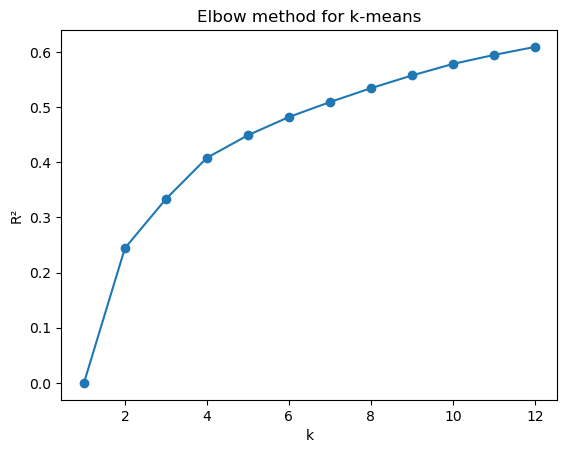

k=2, silhouette score=0.241
k=3, silhouette score=0.199
k=4, silhouette score=0.195
k=5, silhouette score=0.196
k=6, silhouette score=0.184
k=7, silhouette score=0.167
k=8, silhouette score=0.169
k=9, silhouette score=0.163
k=10, silhouette score=0.165
k=11, silhouette score=0.169
k=12, silhouette score=0.175


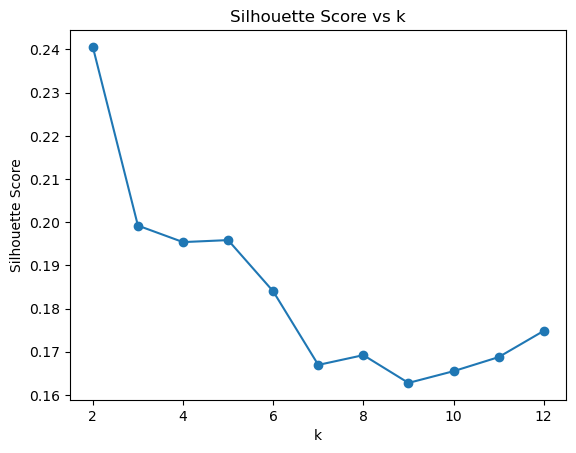

In [12]:

################### USGS data processing AND CLUSTERING ##########################
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

df = data_by_state.copy()

df.to_csv('data_states_processed.csv', index=False)


# === Stage 1: Ion & TDS Processing ===
# Define cation and anion columns in mol/L
cations = ['model_Ca_molL', 'model_Mg_molL', 'model_Na_molL', 'model_K_molL']
anions = ['model_Cl_molL', 'model_SO4_molL', 'model_C_molL']       # treating C as bicarbonate (HCO3-)
silica_col = 'model_Si_molL'
dissolved_solids_col = 'model_TDS_mgL'

# Charges for equivalent calculations
charges = {
    'model_Ca_molL': 2,
    'model_Mg_molL': 2,
    'model_Na_molL': 1,
    'model_K_molL': 1,
    'model_Cl_molL': 1,
    'model_SO4_molL': 2,
    'model_C_molL': 1 # treating C as bicarbonate (HCO3-)
}

# Calculate equivalents for all major ions (mol/L × charge = eq/L)
for ion in cations + anions:
    df[ion + '_eq'] = df[ion] * charges[ion]

# Totals
df['total_cations_eq'] = df[[c + '_eq' for c in cations]].sum(axis=1)
df['total_anions_eq']  = df[[a + '_eq' for a in anions]].sum(axis=1)


# Fractions
for ion in cations:
    df[ion + '_frac'] = df[ion + '_eq'] / df['total_cations_eq']
for ion in anions:
    df[ion + '_frac'] = df[ion + '_eq'] / df['total_anions_eq']

# Print just the new columns created
#new_cols = [ion + '_eq' for ion in cations + anions] + ['total_cations_eq', 'total_anions_eq']
#print(df[new_cols].head())

# Silica fraction
df['total_ion_molL'] = (
    df[[ion + '_eq' for ion in cations + anions]]
    .div([charges[i] for i in cations + anions], axis=1)
    .sum(axis=1)
)
df['model_Si_molL_frac'] = df['model_Si_molL'] / df['total_ion_molL']

# Log transform TDS
df['TDS_log10'] = np.log10(df[dissolved_solids_col])


# === Stage 2: Data Normalization ===
# Prepare dataframe for clustering
untouched = ['model_pH', 'model_temp_c']
features = [col for col in df.columns if col.endswith('_frac')] + ['TDS_log10'] + untouched
X = df[features]
print("Features used for clustering:", X.columns.tolist())

# Count NaNs in each column
print(df[features].isna().sum())

# Count number of NaN values
num_nan = df['model_C_molL'].isna().sum()

# Count number of zero values (excluding NaNs)
num_zero = (df['model_C_molL'] == 0).sum()

print(f"Number of NaN values in model_C_molL: {num_nan}")
print(f"Number of zero values in model_C_molL: {num_zero}")

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# R² vs k
K_range = range(1, 13)
r2_values = []
tot_ss = np.sum((X_scaled - X_scaled.mean(axis=0)) ** 2)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    between_ss = tot_ss - km.inertia_
    r2_values.append(between_ss / tot_ss)

plt.plot(K_range, r2_values, marker='o')
plt.xlabel('k')
plt.ylabel('R²')
plt.title('Elbow method for k-means')
plt.show()

# Final k=4 (example)
k_optimal = 4
km_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df['Cluster'] = km_final.fit_predict(X_scaled)

# Save results
#df.to_csv("geochem_clusters_with_metadata.csv", index=False)

sil_scores = []
K_range = range(2, 13)  # silhouette score not defined for k=1

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    sil_scores.append(score)
    print(f"k={k}, silhouette score={score:.3f}")

# Plot the silhouette scores
plt.figure()
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.show()



In [13]:
k_optimal = 4  # Found via elbow method and same as what USGS found
km_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df['Cluster'] = km_final.fit_predict(X_scaled)

print(df['Cluster'].value_counts())

cluster_means = pd.DataFrame(
    km_final.cluster_centers_, columns=X.columns
)
print(cluster_means)


Cluster
3    1376
2    1371
0    1066
1     997
Name: count, dtype: int64
   model_Ca_molL_frac  model_Mg_molL_frac  model_Na_molL_frac  \
0            1.101460            0.969024           -1.168094   
1           -0.440635           -0.209984            0.400574   
2            0.429860            0.413342           -0.489646   
3           -0.962196           -1.010357            1.102404   

   model_K_molL_frac  model_Cl_molL_frac  model_SO4_molL_frac  \
0          -0.288424           -1.072472             1.398846   
1          -0.046285            1.132461            -0.489329   
2           0.298501            0.020730            -0.441509   
3          -0.039758           -0.010354            -0.290546   

   model_C_molL_frac  model_Si_molL_frac  TDS_log10  model_pH  model_temp_c  
0          -0.461267            0.085555   0.105941 -0.353495     -0.575167  
1          -0.883998           -0.601834   1.147662 -0.146354      0.173254  
2           0.584224            0.427787

In [21]:
import seaborn as sns
# Attach cluster labels to your original df
df['Cluster'] = km_final.labels_

# Calculate means (and std) for each cluster
cluster_profile = df.groupby('Cluster')[features].agg(['mean', 'std'])

print(cluster_profile)

# Number of features to plot
num_features = len(features)

# Make the figure tall enough for all features (adjust height as needed)
fig, axes = plt.subplots(num_features, 1, figsize=(7, 4*num_features), constrained_layout=True)

# If only one feature, axes won't be a list, so wrap it
if num_features == 1:
    axes = [axes]

for i, feature in enumerate(features):
    sns.boxplot(data=df, x='Cluster', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} by Cluster')

# Save to a single file (e.g., PDF for multi-page, or PNG for single image)
plt.savefig('usgs/boxplots/all_features_by_cluster.png', dpi=300)

plt.close(fig)

        model_Ca_molL_frac           model_Mg_molL_frac            \
                      mean       std               mean       std   
Cluster                                                             
0                 0.467644  0.173616           0.262321  0.098766   
1                 0.154127  0.112205           0.120094  0.081331   
2                 0.331443  0.135771           0.195264  0.094594   
3                 0.048100  0.056935           0.023703  0.034375   

        model_Na_molL_frac           model_K_molL_frac            \
                      mean       std              mean       std   
Cluster                                                            
0                 0.264979  0.167178          0.005056  0.004601   
1                 0.717471  0.161976          0.008308  0.009038   
2                 0.460382  0.156537          0.012910  0.021142   
3                 0.919807  0.085103          0.008390  0.008879   

        model_Cl_molL_frac            .

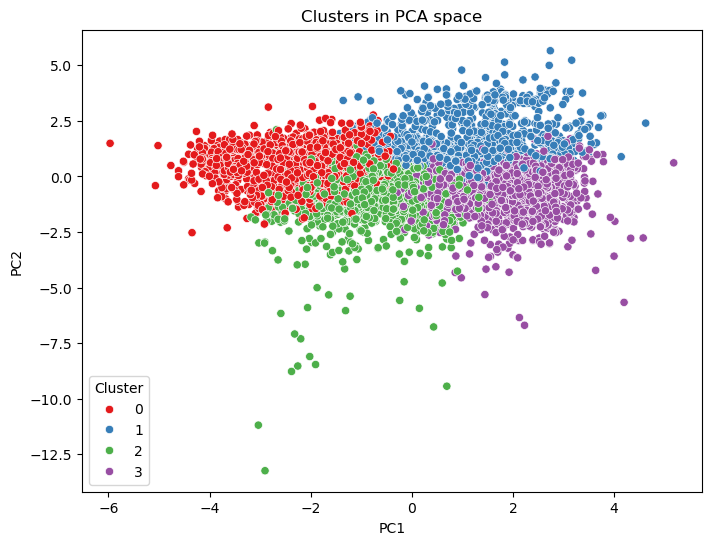

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster'], palette='Set1')
plt.title('Clusters in PCA space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

states = df['state_alpha'].unique()
n_states = len(states)

# Prepare figures: one for all elbow plots, one for all silhouette plots
fig_elbow, axes_elbow = plt.subplots(n_states, 1, figsize=(7, 4*n_states), constrained_layout=True)
fig_sil, axes_sil = plt.subplots(n_states, 1, figsize=(7, 4*n_states), constrained_layout=True)

# If only one state, axes is not a list--wrap it
if n_states == 1:
    axes_elbow = [axes_elbow]
    axes_sil = [axes_sil]

for idx, state in enumerate(states):
    X_state = X[df['state_alpha'] == state]
    print(f"\nState: {state}, Shape: {X_state.shape}")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_state)
    
    # Elbow method
    r2_values = []
    k_max = min(12, len(X_state) - 1)
    elbow_k_range = range(1, k_max+1)
    tot_ss = np.sum((X_scaled - X_scaled.mean(axis=0)) ** 2)
    for k in elbow_k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(X_scaled)
        between_ss = tot_ss - km.inertia_
        r2_values.append(between_ss / tot_ss)
    axes_elbow[idx].plot(list(elbow_k_range), r2_values, marker='o')
    axes_elbow[idx].set_xlabel('k')
    axes_elbow[idx].set_ylabel('R²')
    axes_elbow[idx].set_title(f'Elbow: {state}')

    # Silhouette scores
    sil_scores = []
    sil_k_range = range(2, min(13, len(X_state)))
    for k in sil_k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        sil_scores.append(score)
        print(f"State={state}, k={k}, silhouette score={score:.3f}")
    axes_sil[idx].plot(list(sil_k_range), sil_scores, marker='o')
    axes_sil[idx].set_xlabel('k')
    axes_sil[idx].set_ylabel('Silhouette Score')
    axes_sil[idx].set_title(f'Silhouette: {state}')

# Save both figures
fig_elbow.savefig("usgs/states_elbow.png", dpi=300)
plt.close(fig_elbow)

fig_sil.savefig("usgs/states_silhouette.png", dpi=300)
plt.close(fig_sil)



State: NM, Shape: (163, 11)
State=NM, k=2, silhouette score=0.326
State=NM, k=3, silhouette score=0.289
State=NM, k=4, silhouette score=0.318
State=NM, k=5, silhouette score=0.325
State=NM, k=6, silhouette score=0.220
State=NM, k=7, silhouette score=0.239
State=NM, k=8, silhouette score=0.191
State=NM, k=9, silhouette score=0.251
State=NM, k=10, silhouette score=0.267
State=NM, k=11, silhouette score=0.237
State=NM, k=12, silhouette score=0.273

State: TX, Shape: (2388, 11)
State=TX, k=2, silhouette score=0.280
State=TX, k=3, silhouette score=0.264
State=TX, k=4, silhouette score=0.213
State=TX, k=5, silhouette score=0.221
State=TX, k=6, silhouette score=0.224
State=TX, k=7, silhouette score=0.205
State=TX, k=8, silhouette score=0.195
State=TX, k=9, silhouette score=0.197
State=TX, k=10, silhouette score=0.202
State=TX, k=11, silhouette score=0.201
State=TX, k=12, silhouette score=0.189

State: FL, Shape: (386, 11)
State=FL, k=2, silhouette score=0.437
State=FL, k=3, silhouette score=

In [24]:
state_k_map = {
    "NM": 5,
    "TX": 6,
    "FL": 5,
    "CA": 4,
    "AZ": 6
}

print("Features:", features)

results = {}
output_folder = "usgs/boxplots"
# FIRST LOOP: Cluster per state and collect results
for state, k_opt in state_k_map.items():
    print(f"\n--- Analyzing {state} (k={k_opt}) ---")
    df_state = df[df['state_alpha'] == state].copy()
    X_state = df_state[features]
    
    # Ensure clean data
    X_state = X_state.replace([np.inf, -np.inf], np.nan).dropna()
    df_state = df_state.loc[X_state.index]
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_state)

    # Perform k-means
    km = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
    df_state['Cluster'] = km.fit_predict(X_scaled)

    # (Optional) Show cluster sizes and means for this state
    print(df_state['Cluster'].value_counts())
    print(df_state.groupby('Cluster')[features].mean())

    # Save or store result for later use
    results[state] = df_state
    # df_state.to_csv(f"geochem_clusters_{state}.csv", index=False)



# SECOND LOOP: Generate and save summary boxplots per state

for state, df_state in results.items():
    n_features = len(features)
    n_cols = 3  # Adjust as needed for aesthetics
    n_rows = int(np.ceil(n_features / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for idx, feature in enumerate(features):
        ax = axes[idx]
        sns.boxplot(x='Cluster', y=feature, data=df_state, ax=ax)
        ax.set_title(f"{feature} by Cluster in {state}")
    # Hide any unused axes
    for i in range(len(features), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    # Save in boxplots folder
    plt.savefig(os.path.join(output_folder, f"Cluster_Boxplots_{state}.png"), dpi=300)
    plt.close(fig)  # Free memory

    print(f"{state} saved as Cluster_Boxplots_{state}.png")


Features: ['model_Ca_molL_frac', 'model_Mg_molL_frac', 'model_Na_molL_frac', 'model_K_molL_frac', 'model_Cl_molL_frac', 'model_SO4_molL_frac', 'model_C_molL_frac', 'model_Si_molL_frac', 'TDS_log10', 'model_pH', 'model_temp_c']

--- Analyzing NM (k=5) ---
Cluster
1    96
4    21
0    20
3    16
2    10
Name: count, dtype: int64
         model_Ca_molL_frac  model_Mg_molL_frac  model_Na_molL_frac  \
Cluster                                                               
0                  0.189486            0.082670            0.721318   
1                  0.452756            0.165720            0.370687   
2                  0.274564            0.062949            0.636012   
3                  0.202869            0.090213            0.660330   
4                  0.072247            0.022193            0.900632   

         model_K_molL_frac  model_Cl_molL_frac  model_SO4_molL_frac  \
Cluster                                                               
0                 0.006527     

In [25]:
from sklearn.decomposition import PCA
output_folder = "usgs/pca"
for state, df_state in results.items():
    # Extract features and standardize, as used in clustering
    X_state = df_state[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_state)

    # PCA transformation
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_state['Cluster'], palette='Set1', s=30)
    plt.title(f'Clusters in PCA space: {state}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"PCA_Clusters_{state}.png"), dpi=300)
    plt.close()

    print(f"{state} PCA plot saved as PCA_Clusters_{state}.png")

"""
# Print PCA loadings as a DataFrame
loadings = pd.DataFrame(
    pca.components_.T,  # transpose so rows = features, columns = PCs
    columns=['PC1', 'PC2'],
    index=features      # features in your clustering
)
print(loadings)
"""

NM PCA plot saved as PCA_Clusters_NM.png
TX PCA plot saved as PCA_Clusters_TX.png
FL PCA plot saved as PCA_Clusters_FL.png
CA PCA plot saved as PCA_Clusters_CA.png
AZ PCA plot saved as PCA_Clusters_AZ.png


"\n# Print PCA loadings as a DataFrame\nloadings = pd.DataFrame(\n    pca.components_.T,  # transpose so rows = features, columns = PCs\n    columns=['PC1', 'PC2'],\n    index=features      # features in your clustering\n)\nprint(loadings)\n"